In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install ipyplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.utils import shuffle
import ipyplot
from tensorflow.keras.layers import*
from tensorflow.keras.models import*
from tensorflow.keras.losses import*
from tensorflow.keras.optimizers import*
import os
import math
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


In [ ]:
training_label_path = '/content/drive/MyDrive/Colab Notebooks/labels.npy'
training_file_path = '/content/drive/MyDrive/Colab Notebooks/myarr.npy'
testing_file_path = '/content/drive/MyDrive/Colab Notebooks/myarr_testing.npy'
testing_label_path = '/content/drive/MyDrive/Colab Notebooks/labels_testing_1.npy'

training_images,training_labels,testing_images,testing_labels=np.load(training_file_path),np.load(training_label_path),np.load(testing_file_path),np.load(testing_label_path)
print("shape of training data",training_images.shape,",",training_labels.shape)
print("shape of testing data",testing_images.shape,",",testing_labels.shape)

shape of training data (271, 512, 512, 3) , (271, 5)
shape of testing data (25, 512, 512, 3) , (25, 5)


In [ ]:
print("shape of testing data",testing_images.shape,",",testing_labels.shape)
training_images, training_labels = shuffle(training_images, training_labels)
testing_images,testing_labels = shuffle(testing_images,testing_labels)
print("shape of testing data",testing_images.shape,",",testing_labels.shape)

shape of testing data (25, 512, 512, 3) , (25, 5)
shape of testing data (25, 512, 512, 3) , (25, 5)



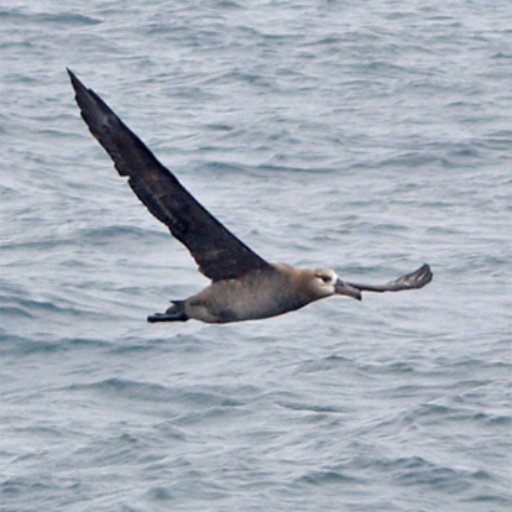
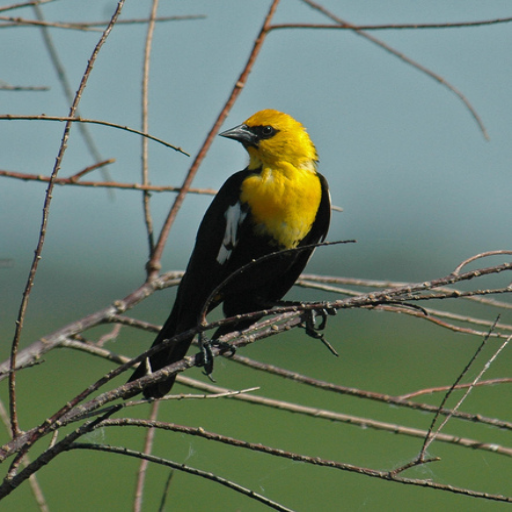
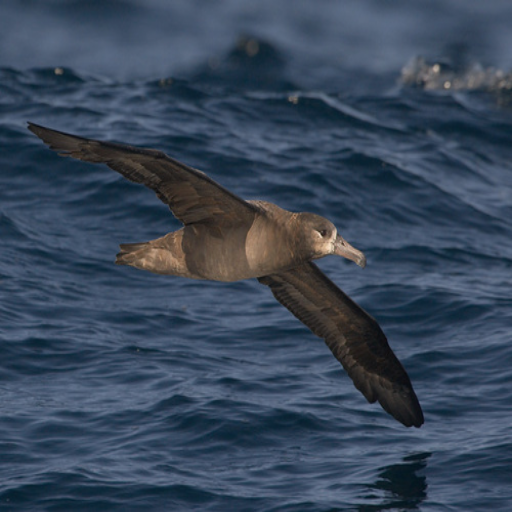
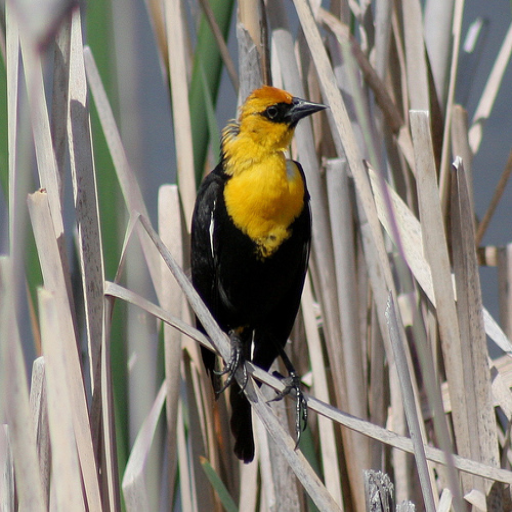
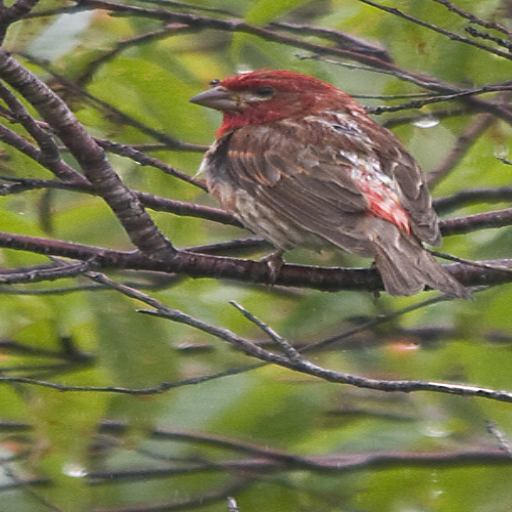
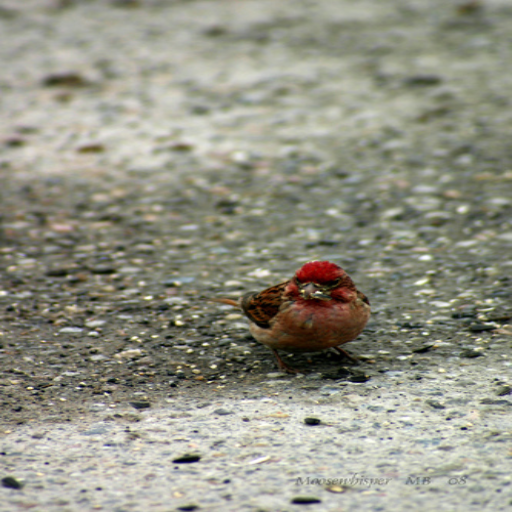
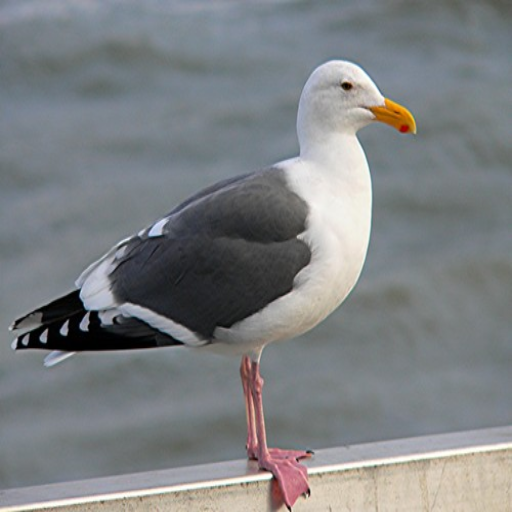
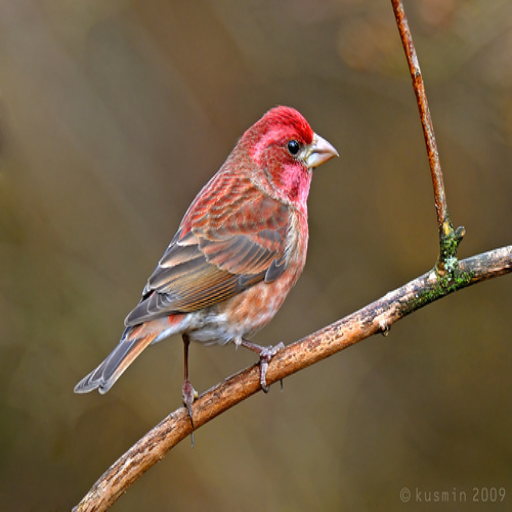
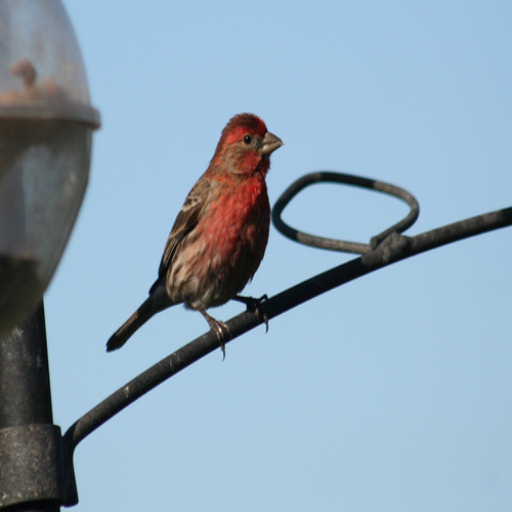
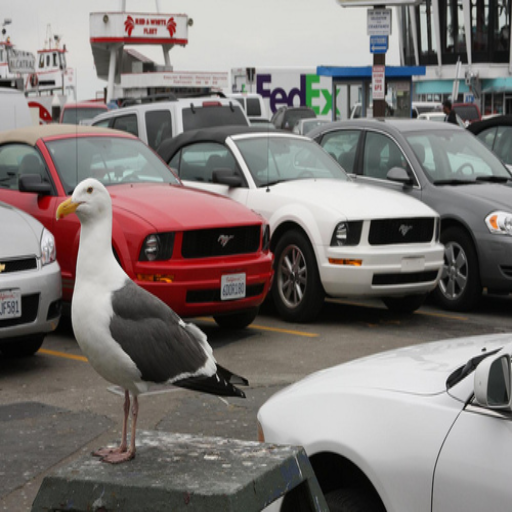


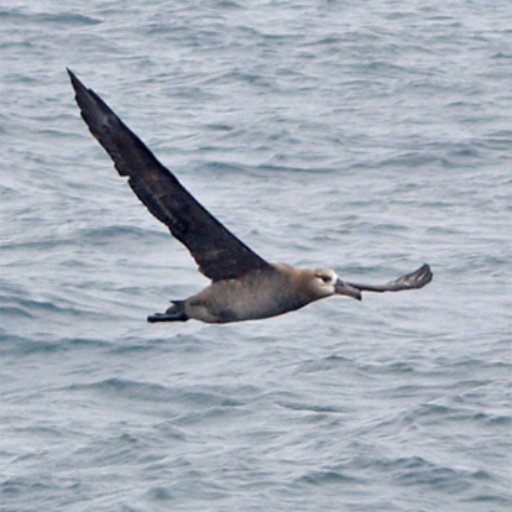
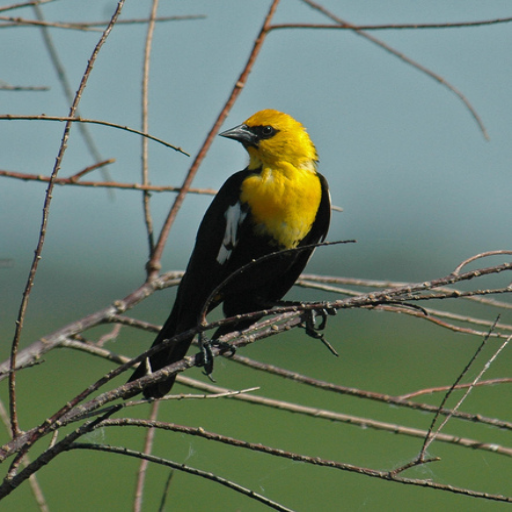
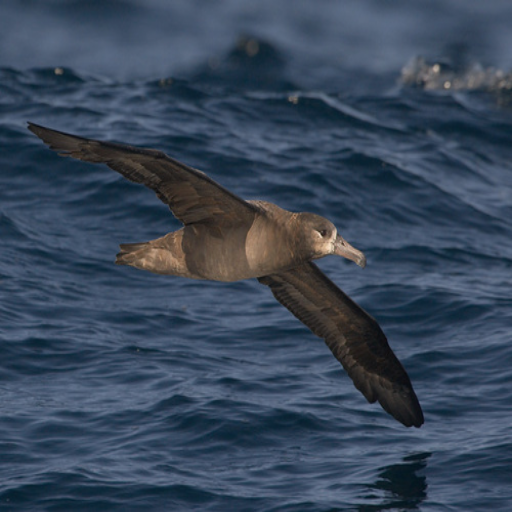
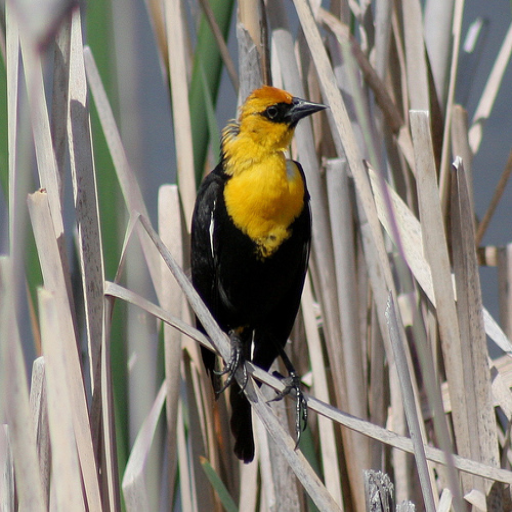
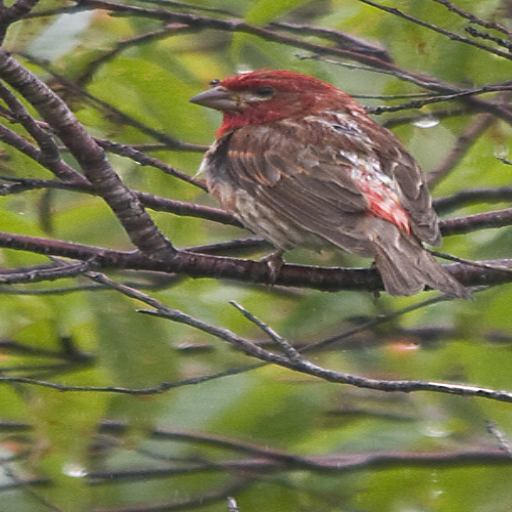
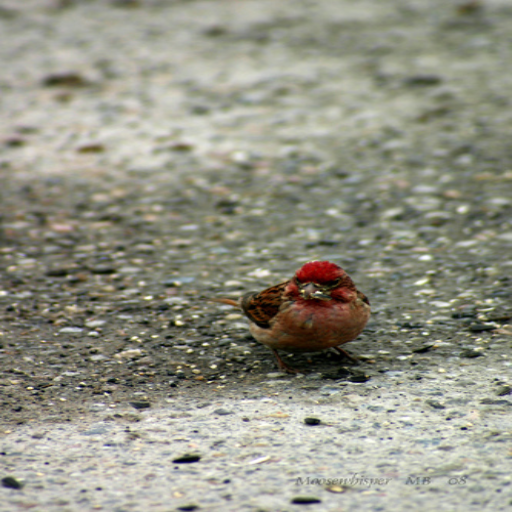
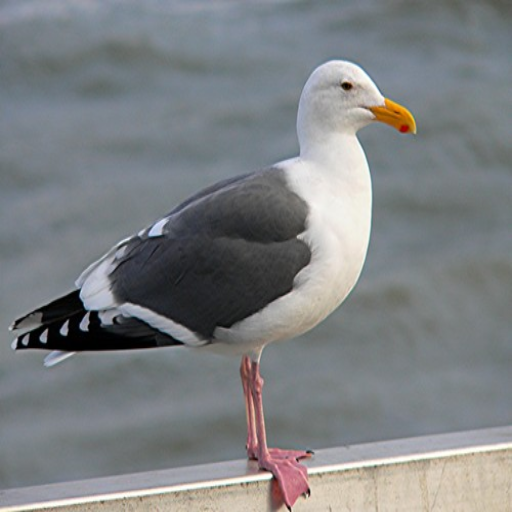
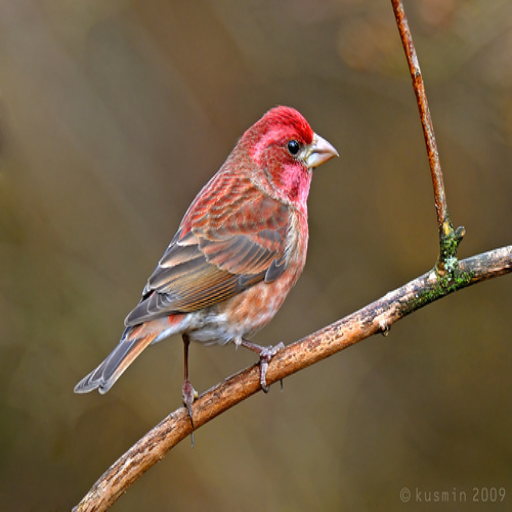
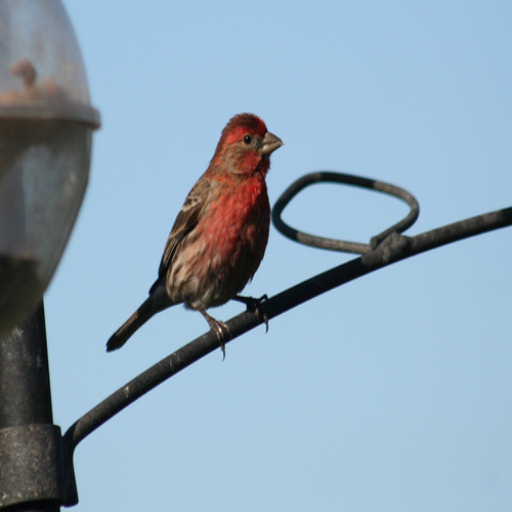
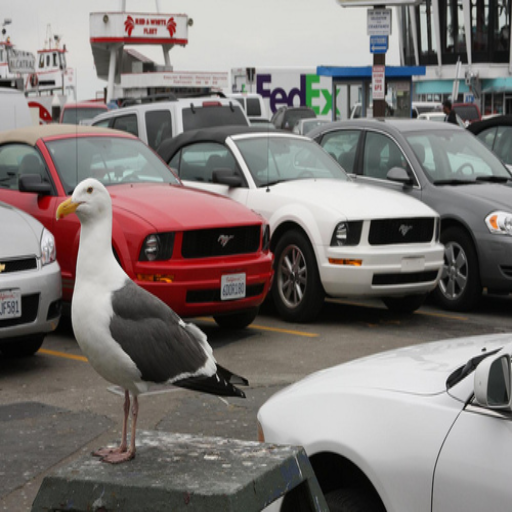

[[1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]]


In [ ]:
ipyplot.plot_images(training_images[:,:,:,::-1],max_images = 10, img_width = 100)
print(training_labels[:10])

In [ ]:
classes = 5

#model

inputs = Input((512,512,3))

conv1 = Conv2D(8,3,activation = 'relu', padding = 'same')(inputs)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

conv2 = Conv2D(16,3,activation = 'relu', padding = 'same')(pool1)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2,2))(conv2)


conv3 = Conv2D(32,3,activation = 'relu', padding = 'same')(pool2)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

conv4 = Conv2D(64,3,activation = 'relu', padding = 'same')(pool3)
conv4 = BatchNormalization()(conv4)
pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

conv5 = Conv2D(128,3,activation = 'relu', padding = 'same')(pool4)
conv5 = BatchNormalization()(conv5)
drop5 = Dropout(0.25)(conv5)
x = GlobalAveragePooling2D()(drop5)
x = Dense(128,activation = 'relu', name = 'Dense_1', dtype='float32')(x)
x = Dense(64,activation = 'relu', name = 'Dense_2', dtype='float32')(x)
x = Dense(8,activation = 'relu', name = 'Dense_3', dtype='float32')(x)
x = Dense(classes,activation = 'softmax', name = 'Output', dtype='float32')(x)

my_model = Model(inputs = [inputs], outputs=[x])

my_optimiser = Adam(lr = 0.00001)
my_model.compile(loss='categorical_crossentropy',optimizer = my_optimiser,metrics = ['categorical_accuracy'])
print("done")
my_model.summary()



done
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 512, 512, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      1168      
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 16)     6

In [ ]:
def decaying_cosine_annealing_scheduler(epoch):
    """
        A step rate scheduler for setting the learning rate for each epoch.
        :param epoch: current epoch
        :return: learning rate for current epoch
        """
    learning_rate_min = 1e-6
    original_learning_rate_max = 1e-3
    original_cycle_length = 15
    epochs_per_cycle = original_cycle_length-(int(epoch/original_cycle_length))
    learning_rate_max = original_learning_rate_max/((int(epoch/original_cycle_length))+1)
    #print(learning_rate_max,learning_rate_min, epoch, epochs_per_cycle)

    return learning_rate_min + (learning_rate_max - learning_rate_min) * \
           (1 + math.cos(math.pi * (epoch % epochs_per_cycle) / epochs_per_cycle)) / 2


In [ ]:
major_revision, minor_revision = 1,1
model_save_path = "/content/drive/MyDrive/Colab Notebooks/models/"
log_save_path =  "/content/drive/MyDrive/Colab Notebooks/logs/"


file_path = os.path.join(model_save_path, 'm%i-%i.h5' % (major_revision, minor_revision))
checkpoints_callback = tf.keras.callbacks.ModelCheckpoint(file_path, monitor= 'val_categorical_accuracy', verbose = 1, mode='max', save_best_only=True, save_freq='epoch')

learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(decaying_cosine_annealing_scheduler, verbose=True)

file = open(os.path.join(log_save_path, 'log-%i-%i.txt' % (major_revision, minor_revision)),'a+')

text_logging_callback = tf.keras.callbacks.LambdaCallback(
on_epoch_end=lambda epoch, logs: file.write('####EPOCH %i\n' % (epoch + 1) + '#### VALIDATION ACCURACY =%.5f \n' % logs['val_categorical_accuracy'])
)

my_callbacks = [checkpoints_callback, learning_rate_callback, text_logging_callback]


In [ ]:
epochs = 100

my_model_history = my_model.fit(x=training_images,y=training_labels,epochs = epochs,callbacks=my_callbacks,validation_split=0.1)

file.close()


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 1.5847 - categorical_accuracy: 0.2058
Epoch 1: val_categorical_accuracy improved from -inf to 0.17857, saving model to /content/drive/MyDrive/Colab Notebooks/models/m1-1.h5
8/8 [==============================] - 20s 597ms/step - loss: 1.5847 - categorical_accuracy: 0.2058 - val_loss: 1.5917 - val_categorical_accuracy: 0.1786 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.000989084726566536.
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 1.4919 - categorical_accuracy: 0.3416
Epoch 2: val_categorical_accuracy improved from 0.17857 to 0.25000, saving model to /content/drive/MyDrive/Colab Notebooks/models/m1-1.h5
8/8 [==============================] - 2s 202ms/step - loss: 1.4919 - categorical_accuracy: 0.3416 - val_loss: 1.5614 - val_categorical_accuracy: 0.2500 - lr: 9.8908e-04

Epoch 3: LearningRateScheduler setti

1/1 [==============================] - 1s 786ms/step
(25, 5)


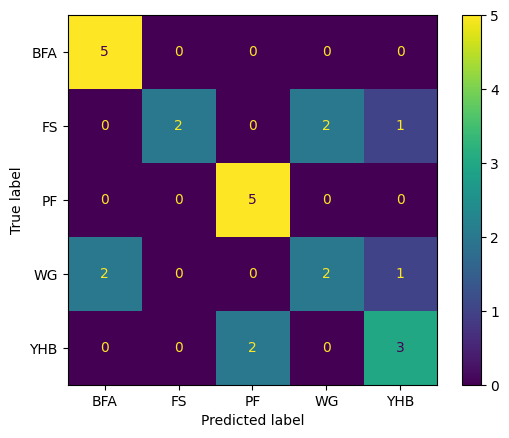

In [ ]:
my_predictions = my_model.predict(testing_images)
print(my_predictions.shape)
classes = ['BFA','FS','PF','WG','YHB']
cmd = ConfusionMatrixDisplay((confusion_matrix(list(np.argmax(testing_labels, axis=1)), list(np.argmax(my_predictions, axis=1)))), display_labels=classes)
cmd.plot()
plt.show()